In [5]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Over the last few months, Moko and I decided that we wanted to better understand the theory behind **Deep Learning** and to implement research papers using Python and Keras. Our plan is to pursue the [Deep Learning Roadmap](https://github.com/floodsung/Deep-Learning-Papers-Reading-Roadmap) and implement code for each of these papers one by one. Hopefully, week by week you'll be posts by us outlining results from our experiments. 

## Objective 

Today, we decided to replicate the results of [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by Xavier Glorot and Yoshua Bengio. 

Setup for any Deep Learning model is as follows:
* Neural Network Architecture: Feed Forward, Convolutional, Recurrent...
* Weight Initialization
* Cost Function
* Optimization
* Hyperparameter Selection

Although this paper is from 2010, it discusses the most crucial element of Deep Learning models. Without proper weight initialization, a model will not effectively learn and take longer to converge and generalize well. This is a waste of GPU resources and time. 

This paper tests the effect of different weight initialization techniques and activation functions on training time, convergence and accuracy for Feed Forward Neural Networks. 

## Datasets

### MNIST

[This dataset does not require much introduction.](http://yann.lecun.com/exdb/mnist/) 

Its a collection of 28x28 grayscale images of digits 0 to 9.

* Training Set: 50000 images
* Test Set: 10000 images

In [18]:
X_train.mean(axis=0).shape

(32, 32, 3)

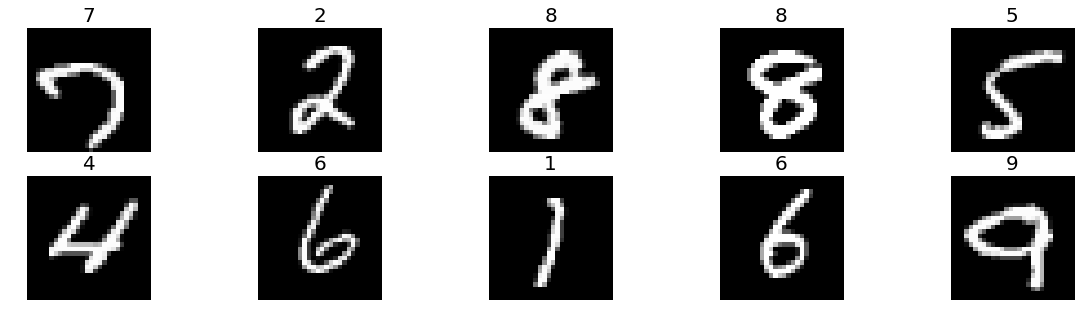

In [6]:
from tensorflow.python.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

fig = plt.figure(figsize=(20, 5))

for ii in range(10):
    jj = np.random.choice(range(len(X_train)))
    imgplot = fig.add_subplot(2,5,ii+1) 
    imgplot.imshow(X_train[jj], cmap=plt.get_cmap('gray'))
    imgplot.set_title(y_train[jj], fontsize=20)
    imgplot.axis('off')

### CIFAR10

[This dataset does not require much introduction either.](https://www.cs.toronto.edu/~kriz/cifar.html) 

Its a collection of 32x32 grayscale images of 10 classes of objects. Below are labels for the objects - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.  

* Training Set: 50000 images
* Test Set: 10000 images

Using TensorFlow backend.


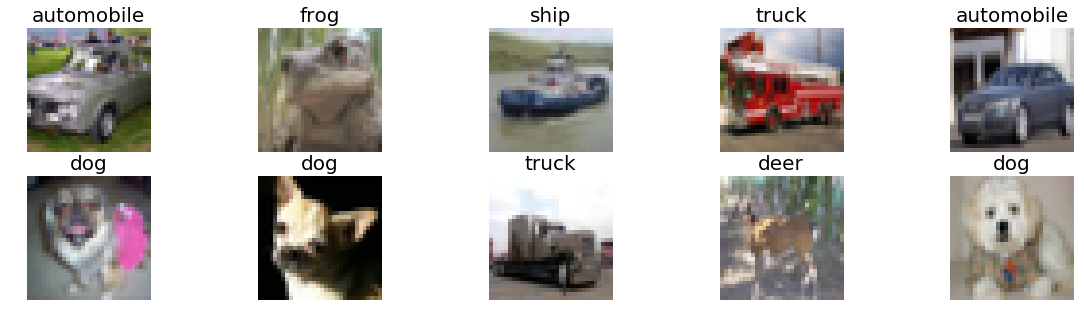

In [17]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
              'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(20, 5))

for ii in range(10):
    jj = np.random.choice(range(len(X_train)))
    label = [labels_map[j] for j in y_train[jj]][-1]
    imgplot = fig.add_subplot(2,5,ii+1) 
    imgplot.imshow(X_train[jj], cmap=plt.get_cmap('gray'))
    imgplot.set_title(label, fontsize=20)
    imgplot.axis('off')

### Shapeset

This dataset was created by Xavier Glorot and scripts can be found [here](https://github.com/glorotxa/Shapeset). This dataset is created on the fly unlike the previous two datasets. 

For this paper Shapeset-3x2 is used, contains images of one or two shapes of combinations of triangles, parallelograms, ellipses. 3x2 comes from the fact there are 9 classes for this dataset i.e. one triangle, two triangles, triangle and ellipse, triangle and parallelogram, etc. 

This is considered an infinite dataset, so there is no fixed training and test set. As done in the experiments of this paper, we save 300 examples for the test set. This test set is used to examine the histograms of the weights during the training process and convergence tests. 

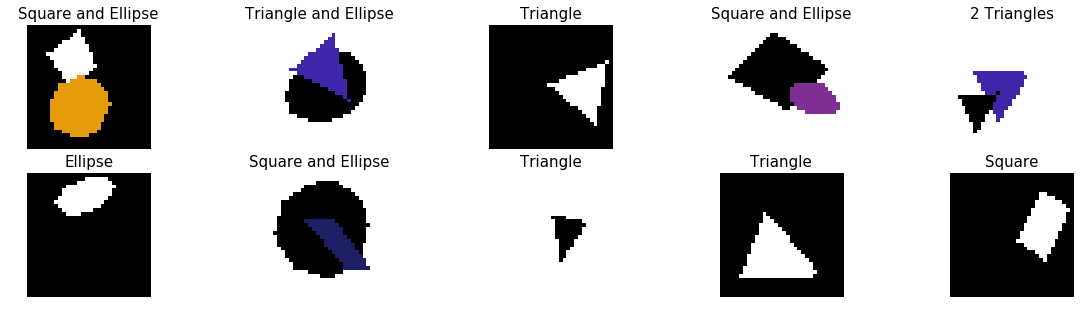

In [4]:
import sys
sys.path.insert(0, '/home/joshi/xavier/src/data/')
from Shapeset.curridata import *
from Shapeset.buildfeaturespolygon import *
from Shapeset.polygongen import *

genparams = {'inv_chance' : 0.5, 'img_shape' : (32,32), 'n_vert_list' : [3,4,20], 'fg_min' : 0.55, 'fg_max' : 1.0,\
        'bg_min' :0.0, 'bg_max': 0.45, 'rot_min' : 0.0, 'rot_max' : 1, 'pos_min' : 0, 'pos_max' : 1, \
        'scale_min' : 0.2, 'scale_max':0.8, 'rotation_resolution' : 255,\
        'nb_poly_max' :2, 'nb_poly_min' :1, 'overlap_max' : 0.5, 'poly_type' :2, 'rejectionmax' : 50,\
        'overlap_bool':True}

datagenerator=Polygongen
funclist =[buildimage,buildedgesangle,builddepthmap,buildidentity,buildsegmentation,output,buildedgesanglec]
dependencies = [None,{'segmentation':4},None,None,{'depthmap':2},None,{'segmentation':4}]
funcparams={'neighbor':'V8','gaussfiltbool' : False, 'sigma' : 0.5 , 'size': 5}
nfeatures = 6

batchsize = 10
seed = 0 
funcparams.update({'neg':True}) 
 
def convertout(out):
    target =    0*((out[:,0]==1) * (out[:,1] == 0) * (out[:,2]==0)) +\
                1*((out[:,0]==0) * (out[:,1] == 1) * (out[:,2]==0)) +\
                2*((out[:,0]==0) * (out[:,1] == 0) * (out[:,2]==1)) +\
                3*((out[:,0]==1) * (out[:,1] == 1) * (out[:,2]==0)) +\
                4*((out[:,0]==0) * (out[:,1] == 1) * (out[:,2]==1)) +\
                5*((out[:,0]==1) * (out[:,1] == 0) * (out[:,2]==1)) +\
                6*((out[:,0]==2) * (out[:,1] == 0) * (out[:,2]==0)) +\
                7*((out[:,0]==0) * (out[:,1] == 2) * (out[:,2]==0)) +\
                8*((out[:,0]==0) * (out[:,1] == 0) * (out[:,2]==2))
    return target

labels_map = ['Triangle', 'Square', 'Ellipse', 'Triangle and Square',
             'Square and Ellipse', 'Triangle and Ellipse', '2 Triangles',
             '2 Squares', '2 Ellipses']

curridata=Curridata(nfeatures,datagenerator,genparams,funclist,dependencies,funcparams,batchsize,seed)

curridata.next() 
curridata.image 

fig = plt.figure(figsize=(20, 5))

for ii in range(10):
    label = labels_map[convertout(curridata.output)[ii]]
    img = curridata._Curridata__features[0][ii]
    imgplot = fig.add_subplot(2,5,ii+1) 
    imgplot.imshow(img.reshape(32, 32), cmap=plt.get_cmap('CMRmap'))
    imgplot.set_title(label, fontsize=15)
    imgplot.axis('off')

## Experiment Guidelines

### Initialization Schemes:
* Random Initialization
 
   $W_{ij} \sim U[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}]$
    
    Where U[-a, a] is the uniform distribution of interval (-a, a) and n is the number of neurons from the previous layer.



* Xavier Initialization 

    $W_{ij} \sim U[-\frac{\sqrt{6}}{\sqrt{n_{j} + n_{j+1}}}, \frac{\sqrt{6}}{\sqrt{n_{j} + n_{j+1}}}]$
    
    Where $n_{j}$ is the neurons from the previous layer and $n_{j+1}$ is the number of neurons from the next layer. 

### Activation Functions

* tanh

* sigmoid

* softsign

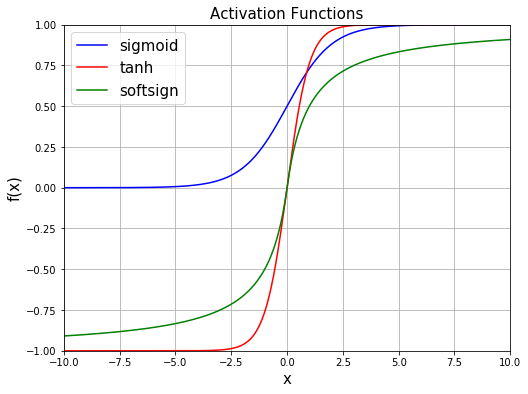

In [5]:
from keras.activations import sigmoid, tanh, softsign

x = np.linspace(-10, 10, 1000)

sess = tf.Session()

x_sigmoid = sigmoid(x).eval(session=sess)
x_tanh = tanh(x).eval(session=sess)
x_softsign = softsign(x).eval(session=sess)

plt.figure(figsize=(8, 6));
plt.plot(x, x_sigmoid, c='b', label='sigmoid');
plt.plot(x, x_tanh, c='r', label='tanh');
plt.plot(x, x_softsign, c='g', label='softsign');
plt.xlim([-10, 10]);
plt.ylim([-1.1, 1.1]);
plt.grid();
plt.title('Activation Functions', fontsize=15);
plt.xlabel('x', fontsize=15);
plt.ylabel('f(x)', fontsize=15);
plt.legend(fontsize=15);

The above figure plots the behaviour of the activation functions for input values ranging from -10 to 10. 

An important observation from the above figure is that each of the activation functions saturate after a value for both positive and negative values. 

What this means is the activation functions output the asme value for a majority of real numbers, unless in that range. 

This is why initialization is important for neural networks. Poor initialization leads to saturation of neurons which can result in constant outputs in the forward passes and exploding/vanishing gradients in the backward pass. 



### Types of Experiments: 

#### Test Error/Convergence Test: 
We evalute the model on a held out test set during the training process. We record test error and test loss for different initialization schemes and activation functions. This test helps us gain a better intuition on the effect of iniitalization of weights and activation functions used on thre training performance i.e. accuracy and time. 

This is done for all the datasets listed above. 

#### Gradients and Activation Study :
We create a held-out test set for Shapeset-3x2. For different initialization schemes and activations functions, we study the gradients and activations of the weights on the test set, during the training process. 

**We did not perform an extensive hyperparameter search for learning rates.**

### Hardware:

We built a computer to train deep learning models and below are the specs using **python** and **bash commands**.

With the specifications below and small datasets, we were able to train models fairly quickly. 

In [6]:
from __future__ import print_function
import psutil
import math
import platform

print('  OS Version: ')
for i in (0 ,2, 3):
    print('     ', platform.uname()[i])
print('\n  CPU Count: ', '\n     ', psutil.cpu_count())
print('\n  RAM Available: ', '\n     ', int(psutil.virtual_memory()[0]/math.pow(2,30)), 'GB')

  OS Version: 
      Linux
      4.13.0-37-generic
      #42~16.04.1-Ubuntu SMP Wed Mar 7 16:03:28 UTC 2018

  CPU Count:  
      8

  RAM Available:  
      31 GB


In [7]:
!nvidia-smi

Fri Apr  6 06:55:17 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P2    55W / 250W |  10625MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 980 Ti  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   58C    P2    72W / 275W |   5778MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Test Error/Convergence Test

Below we'll run through an example of collecting training history on a dataset. Note that this was done for a combination of different initialization schemes and activation functions; the code for other datasets is available on the [github repo](). 

Above, we show a simple example on how to save .h5 files of the model history for an expermient after 5 epochs and access it later to create required plots. 

We do the same for different datasets, activation functions and initialization schemes. 

In the subject paper, models are trained until the model has seen 2.5 million examples. This means training on over 400 epochs for MNIST and CIFAR10. For Shapeset, saves information at every 20k thousand minibatch, where a minibatch is 10 examples. 

Below are plots of the validation error and validation loss for each dataset for different initializations and activations. 

<img src="../model_history/mnist-pickles/MNIST.png" width="1000">

<img src="../model_history/cifar10-pickles/CIFAR10.png" width="1000">

<img src="../model_history/shapeset-pickles/Shapeset.png" width="1000">

### Gradients/Activations Study

Below we'll run through an example of collecting training history on a dataset. Note that this was done for a combination of different initialization schemes and activation functions; the code for other datasets is available on the [github repo](). 